Workflow:

1. Imput Embedding
2. Positional Encoding
3. Multi head attention
4. Add and Norm (layer Normalisation)
5. Feed forward Network
6. Residual Network
7. Encoder
8. Decoder
9. Building Transformer
10. test out transformer
11. tokenizer
12. Loading dataset
13. Validation Loop
14. Training Loop
15. Conclusion


###  Importation

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,random_split
from torch.utils.tensorboard import SummaryWriter
import math
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer
from pathlib import Path
from typing import Any
from tqdm import tqdm
import warnings

### Input Embedding

In [6]:
class InputEmbeddings(nn.Module):
    def __init__(self,d_model : int, vocab_size : int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embeddings = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embeddings(x) * math.sqrt(self.d_model)

# Positional Encoding

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model : int, seq_len : int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)

        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0,d_model,2) * (- math.log(10000)/d_model))

        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # extra dimension for batch_handling ,size :(batch, seq_len, d_model)

        self.register_buffer('pe', pe)  # make the PE non trainable.

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)


### Layer Normalisation

In [8]:
class LayerNormalization(nn.Module):
    def __init__(self, eps : float = 10**-6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1))
        self.beta = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)

        return (x - mean) / std * self.alpha + self.beta

### Feed Forward

In [9]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return self.linear2(x)

### Multihead Attention

In [10]:
class MultiheadAttention(nn.Module):
    def __init__(self, d_model : int, num_heads : int, dropout : float):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        assert d_model % num_heads == 0, "d_model must be divisible by the number of heads"

        self.d_k = d_model // num_heads
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(q, k, v, mask, dropout : nn.Dropout):
        d_k = q.shape[-1]
        attn_scores = ( (q @ k.transpose(-2,-1) ) / math.sqrt(d_k)) # Use d_k here
        if mask is not None:
            attn_scores = attn_scores.masked_fill_(mask == 0, -1e9)

        attn_scores = torch.softmax(attn_scores, dim = -1)

        if dropout is not None:
            attn_scores = dropout(attn_scores)
        return (attn_scores @ v), attn_scores  # (batch, num_heads, seq_len, d_k)



    def forward(self, q, k, v, mask): # Removed dropout argument from forward
        q = self.w_q(q)  # (batch, seq_len, d_model)
        k = self.w_k(k)
        v = self.w_v(v)

        q = q.view(q.shape[0],q.shape[1],self.num_heads, self.d_k).transpose(1,2) # Corrected hum_heads to num_heads
        k = k.view(k.shape[0],k.shape[1],self.num_heads, self.d_k).transpose(1,2) # Corrected hum_heads to num_heads
        v = v.view(v.shape[0],v.shape[1],self.num_heads, self.d_k).transpose(1,2) # Corrected hum_heads to num_heads

        x, attention_score = MultiheadAttention.attention(q, k, v, mask, self.dropout) # Pass self.dropout

        x = x.transpose(1,2).contiguous().view(x.shape[0],-1, self.num_heads * self.d_k) # Changed self.d_model to self.d_k

        return self.w_o(x)

### Residual Connetion

In [11]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout : float):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

### Encoder Block


In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block : MultiheadAttention , feed_forward_block : FeedForward, dropout : float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])


    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x : self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

### Encoder

In [13]:
class Encoder(nn.Module):
    def __init__(self, encoder_blocks : nn.ModuleList):
        super().__init__()
        self.encoder_blocks = encoder_blocks
        self.norm = LayerNormalization()

    def forward(self, x, src_mask):
        for block in self.encoder_blocks:
            x = block(x, src_mask)
        return x

### Decoder block

In [14]:
class DecoderBlock(nn.Module):
    def __init__(self, self_attention_block : MultiheadAttention, cross_attention_block : MultiheadAttention, feed_forward_block : FeedForward, dropout : float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block # Corrected typo
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x : self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x : self.cross_attention_block(x, encoder_output, encoder_output, src_mask)) # Corrected typo
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

### Decoder

In [15]:
class Decoder(nn.Module):
    def __init__(self,decoder_blocks : nn.ModuleList):
        super().__init__()
        self.decoder_blocks = decoder_blocks
        self.norm = LayerNormalization()

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for blocks in self.decoder_blocks:
            x = blocks(x, encoder_output, src_mask, tgt_mask) # Pass encoder_output here
        return self.norm(x)

### Projection Layer

In [16]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model : int, vocab_size : int):
        super().__init__()
        self.projection = nn.Linear(d_model , vocab_size)

    def forward(self, x):
        return torch.log_softmax(self.projection(x), dim = -1)

### Transformer

In [17]:
class Transformer(nn.Module):
    def __init__(self, encoder : Encoder, decoder : Decoder, src_embed : InputEmbeddings, tgt_embed : InputEmbeddings,src_pos : PositionalEncoding, tgt_pos : PositionalEncoding, projection_layer : ProjectionLayer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output, tgt, src_mask, tgt_mask): # Corrected method name to decode
        tgt = self.tgt_embed(tgt) # Corrected variable name to tgt
        tgt = self.tgt_pos(tgt) # Corrected variable name to tgt
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask) # Added encoder_output

    def project(self, x):
        return self.projection_layer(x)

### Building And Intializing Transformer

### Xavier Intialization

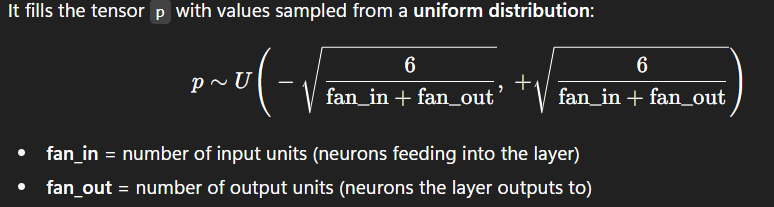

It is especially suitable for tanh or sigmoid activations.

In [18]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:

    src_embed = InputEmbeddings(d_model, src_vocab_size) # Source language
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size) # Target language

    src_pos = PositionalEncoding(d_model, src_seq_len, dropout) # Positional encoding for the source language embeddings
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout) # Positional encoding for the target language embeddings

    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiheadAttention(d_model, h, dropout) # Self-Attention
        feed_forward_block = FeedForward(d_model, d_ff, dropout) # FeedForward
        encoder_blocks.append(EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)) # Appending EncoderBlock to the list of EncoderBlocks

    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiheadAttention(d_model, h, dropout) # Self-Attention
        decoder_cross_attention_block = MultiheadAttention(d_model, h, dropout) # Cross-Attention
        feed_forward_block = FeedForward(d_model, d_ff, dropout) # FeedForward
        decoder_blocks.append(DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)) # Appending DecoderBlock to the list of DecoderBlocks

    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))

    projection_layer = ProjectionLayer(d_model, tgt_vocab_size) # Map the output of Decoder to the Target Vocabulary Space

    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer


### Testing For transformer

Tokenization:

. Word Level
.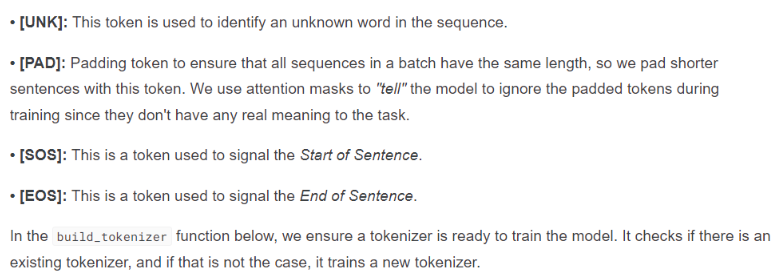



In [19]:
def build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))

    if not Path.exists(tokenizer_path):
      tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]'))
      tokenizer.pre_tokenizer = Whitespace()

      trainer = WordLevelTrainer(
          special_tokens = ["[UNK]","[PAD]","[SOS]","[EOS]"], min_frequency = 2
      )
      tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
      tokenizer.save(str(tokenizer_path))
    else:
      tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer


### Load Dataset

### get_all_sentences function to iterate over the dataset and extract the sentences according to the language pair defined.

In [20]:
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]

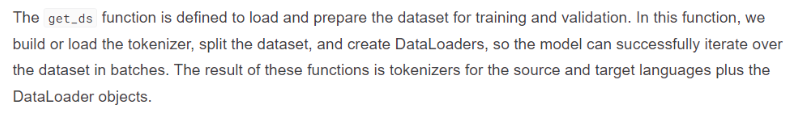

In [21]:
def get_ds(config):
    # loading the dataset
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')
    # Loading or buiding the tokenizer
    tokenizer_src = build_tokenizer(config, ds_raw, config["lang_src"]) # Pass individual language code
    tokenizer_tgt = build_tokenizer(config, ds_raw, config["lang_tgt"]) # Pass individual language code
    # splitting for training and validation
    train_size = int(0.9 * len(ds_raw))
    val_size = len(ds_raw) - train_size
    train_ds_raw, test_ds_raw = random_split(ds_raw, [train_size, val_size])

    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config)
    val_ds = BilingualDataset(test_ds_raw, tokenizer_src, tokenizer_tgt, config)

    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']])
        tgt_ids = tokenizer_tgt.encode(pair['translation'][config['lang_tgt']])
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    # Custom collate function to filter out None values
    def custom_collate_fn(batch):
        # Filter out None values
        batch = list(filter(lambda x: x is not None, batch))
        if len(batch) == 0:
            return None # Return None if the batch is empty after filtering
        return torch.utils.data.dataloader.default_collate(batch)

    # creating DataLoader for training and validation sets
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True, collate_fn=custom_collate_fn) # Add collate_fn
    test_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True, collate_fn=custom_collate_fn) # Add collate_fn

    return train_dataloader, test_dataloader, tokenizer_src, tokenizer_tgt

In [22]:
# prevents the model from having the information about future element in the sequences.
def causal_mask(size):
    mask = torch.triu(torch.ones(1,size,size), diagonal = 1).type(torch.int)
    return mask == 0

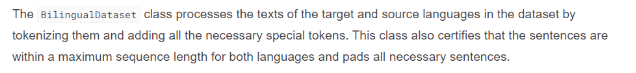

In [23]:
class BilingualDataset(nn.Module):
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, config) -> None:
        super().__init__()
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.ds = ds
        self.seq_len = config['seq_len']
        self.src_lang = config['lang_src']
        self.tgt_lang = config['lang_tgt'] # Corrected typo

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")],dtype = torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype = torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype = torch.int64)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index : Any) -> Any: # Changed return type hint to Any to allow None
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1

        if(enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0):
            # Skip this sample if it's too long
            # print(f"Skipping sentence due to length: Source length {len(enc_input_tokens)}, Target length {len(dec_input_tokens)}")
            return None # Return None to skip this sample

        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(enc_input_tokens, dtype = torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64)
            ]
        )

        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(dec_input_tokens, dtype = torch.int64),
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64)
            ]
        )

        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64)
            ]
        )

        # Assert against seq_len
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input" : encoder_input,
            "decoder_input" : decoder_input,
            "encoder_mask" : (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            "decoder_mask" : (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & causal_mask(decoder_input.size(0)),
            "label" : label,
            "src_text" : src_text,
            "tgt_text" : tgt_text
        }

### Validation Loop
1. greedy_decode : give the model output by obtaining most probable next token
2. run_validation : running the validation in which we decode the models output and compare it with the reference text for the target sentences.

In [24]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    encoder_output = model.encode(source, source_mask)

    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(device)

    while True:
        if decoder_input.size(1) == max_len:
            break

        # Corrected mask type and device
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)
        out = model.decode(encoder_output, decoder_input, source_mask, decoder_mask) # Corrected arguments order
        prob = model.project(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        # Corrected typo and removed extra dimension for concatenation
        decoder_input = torch.cat([decoder_input, torch.empty(1, 1).type_as(source).fill_(next_word.item()).to(device)], dim=1)

        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0)

In [25]:
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval()
    count = 0
    console_width = 80
    with torch.no_grad():
        for batch in validation_ds:
            count += 1
            encoder_input = batch["encoder_input"].to(device)
            encoder_mask = batch["encoder_mask"].to(device)

            assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
            source_text = batch["src_text"][0]
            target_text = batch["tgt_text"][0]

            # Ensure model_out is on CPU before decoding
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy().tolist())


            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')

            if count == num_examples:
                print_msg('-'*console_width)
                break

### Training Loop

In [26]:
def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model

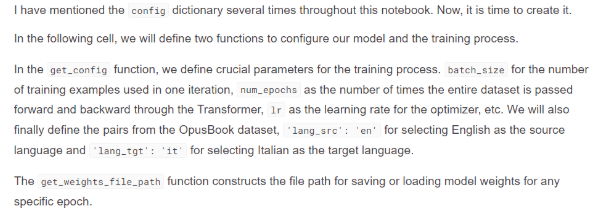

In [27]:
def get_config():
    return{
        'batch_size': 8,
        'num_epochs': 20,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512,
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': '/content/drive/MyDrive/transformer_weights',  # Changed to Google Drive path
        'model_basename': 'tmodel_',
        'preload': 'latest',
        'tokenizer_file': '/content/drive/MyDrive/tokenizer_{0}.json',  # Also save tokenizers to Drive
        'experiment_name': '/content/drive/MyDrive/runs/tmodel'  # Save tensorboard logs too
    }


def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder']
    model_basename = config['model_basename']
    model_filename = f"{model_basename}{epoch}.pt"
    return str(Path('.')/ model_folder/ model_filename)

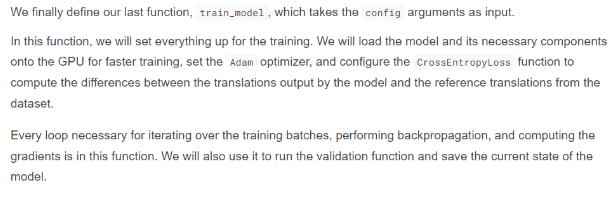

In [28]:
def get_latest_weights_file_path(config):
    """Find the latest checkpoint file"""
    model_folder = config['model_folder']
    model_basename = config['model_basename']

    # Get all weight files
    weights_files = list(Path(model_folder).glob(f"{model_basename}*.pt"))

    if len(weights_files) == 0:
        return None

    # Sort by epoch number and return the latest
    weights_files.sort()
    return str(weights_files[-1])

In [29]:
def train_model(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"using device : {device}")
    Path(config['model_folder']).mkdir(parents = True, exist_ok = True)  # directory to store
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    writer = SummaryWriter(config['experiment_name'])

    optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'], eps = 1e-9)

    initial_epoch = 0
    global_step = 0 # Initialized global_step
    if config['preload'] == 'latest':
        model_filename = get_latest_weights_file_path(config)
        if model_filename:
            print(f'Preloading model {model_filename}')
            state = torch.load(model_filename)
            model.load_state_dict(state['model_state_dict'])
            initial_epoch = state['epoch'] + 1
            optimizer.load_state_dict(state['optimizer_state_dict'])
            global_step = state['global_step']
            print(f'Resuming from epoch {initial_epoch}')
        else:
            print('No checkpoint found, starting from scratch')
    elif config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename)
        model.load_state_dict(state['model_state_dict'])
        initial_epoch = state['epoch'] + 1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step = state['global_step']


    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)

    for epoch in range(initial_epoch, config['num_epochs']):

        batch_iterator = tqdm(train_dataloader, desc = f"Processing Epoch {epoch:02d}")

        for batch in batch_iterator:
            model.train()

            encoder_input = batch['encoder_input'].to(device) # Corrected typo here
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device) # Corrected typo here
            decoder_mask = batch['decoder_mask'].to(device)

            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, decoder_input, encoder_mask, decoder_mask) # Corrected arguments order and mask
            proj_output = model.project(decoder_output)

            label = batch['label'].to(device)

            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

            batch_iterator.set_postfix({"loss" : f"{loss.item():6.3f}"})

            writer.add_scalar('train_loss', loss.item(), global_step)
            writer.flush()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)
        model_filename = get_weights_file_path(config, f"{global_step:02d}")
        torch.save({
            'epoch' : epoch,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(), # Corrected typo
            'global_step' : global_step
        },model_filename)

In [30]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore')
    config = get_config()
    train_model(config)

using device : cuda


README.md: 0.00B [00:00, ?B/s]

en-it/train-00000-of-00001.parquet:   0%|          | 0.00/5.73M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

Max length of source sentence: 309
Max length of target sentence: 274
Preloading model /content/drive/MyDrive/transformer_weights/tmodel_69122.pt
Resuming from epoch 19


Processing Epoch 19: 100%|██████████| 3638/3638 [25:10<00:00,  2.41it/s, loss=2.312]


--------------------------------------------------------------------------------
SOURCE: I objected.
TARGET: Io mi opposi.
PREDICTED: Io mi opposi .
--------------------------------------------------------------------------------
SOURCE: It would have been a good thing for anybody who had come up to that spot with a can of mustard, then: he would have been set up in worlds for the rest of his life.
TARGET: Chiunque ci si fosse presentato allora con un vaso di mostarda avrebbe fatto un ottimo affare: avrebbe avuto dei mondi a disposizione per tutto il resto della vita.
PREDICTED: Sembrava che tutti , che tutti avevano portato in moto con un punto di mostarda , e poi si sarebbe trovato un gran mondo della vita .
--------------------------------------------------------------------------------


In [32]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.1 MB/s eta 0:00:00


In [33]:
def evaluate_model(config, checkpoint_epoch='latest'):
    """Evaluate a trained model and calculate BLEU score"""
    import sacrebleu

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")

    # Load data and tokenizers
    _, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)

    # Load model
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    # Load checkpoint
    if checkpoint_epoch == 'latest':
        model_filename = get_latest_weights_file_path(config)
    else:
        model_filename = get_weights_file_path(config, checkpoint_epoch)

    print(f'Loading model from {model_filename}')
    state = torch.load(model_filename, map_location=device)
    model.load_state_dict(state['model_state_dict'])
    print(f'Model loaded from epoch {state["epoch"]}')

    # Evaluate
    model.eval()
    predictions = []
    references = []

    print("Generating translations...")
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluating"):
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)

            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, config['seq_len'], device)

            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy())
            target_text = batch['tgt_text'][0]

            predictions.append(model_out_text)
            references.append([target_text])

    # Calculate BLEU
    bleu = sacrebleu.corpus_bleu(predictions, references)
    print(f'\n{"="*50}')
    print(f'BLEU Score: {bleu.score:.2f}')
    print(f'{"="*50}')

    return bleu.score, predictions, references

# Run evaluation
config = get_config()
bleu_score, predictions, references = evaluate_model(config, checkpoint_epoch='latest')

# Optional: Show some examples
print("\nSample Translations:")
for i in range(min(5, len(predictions))):
    print(f'\nExample {i+1}:')
    print(f'Reference:  {references[i][0]}')
    print(f'Predicted:  {predictions[i]}')

Using device cuda
Max length of source sentence: 309
Max length of target sentence: 274
Loading model from /content/drive/MyDrive/transformer_weights/tmodel_72760.pt
Model loaded from epoch 19
Generating translations...


Evaluating: 100%|██████████| 3234/3234 [14:20<00:00,  3.76it/s]



BLEU Score: 78.83

Sample Translations:

Example 1:
Reference:  Io sin da piccolo... — cominciò con gli occhi che gli luccicavano, evidentemente contagiato dall’entusiasmo di Levin, così come si è contagiati dallo sbadiglio.
Predicted:  Io sin da piccolo ... — cominciò con gli occhi che gli luccicavano , evidentemente dall ’ entusiasmo di Levin , così come si è dallo sbadiglio .

Example 2:
Reference:  Fate venire la bambina che ha rotto la lavagna.
Predicted:  — Che ha rotto la bambina ?

Example 3:
Reference:  — Fra l'Inghilterra e Thornfield, e....
Predicted:  — Fra l ' Inghilterra e Thornfield , e ....

Example 4:
Reference:  Levin fra di sé biasimava ciò, e non capiva ancora che ella si preparava a quel periodo di attività che stava per giungere per lei, quando sarebbe stata nello stesso tempo la moglie, la padrona di casa e avrebbe portati in sé, avrebbe allevato e educato i propri figli.
Predicted:  Levin fra di sé ciò , ma non capiva che ella si preparava a quel periodo di att